# RNA Trajectory Inference

In [1]:
library(Seurat)
library(tidyverse)
library(dyno)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: dynfeature

Loading required package: dynguidelines

Loading required package: dynmethods

Loading required package: dynplot

Loading required package: dynwrap



In [2]:
# using singularity (docker bugging out)
dynwrap::set_default_config(dynwrap::create_singularity_config(cache_dir = "..."))

### Seurat Object

In [3]:
rna = readRDS("../20200828_RNA_Seurat/sessions/20200913_n27632/seurat.rds")
rna$tech = "rna"

### Configs

In [4]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#F4D5CD,Intermediate,12
2,2,#78A824,Pre-iPSC,15
3,3,#F01D35,Fibroblast-like,5
4,4,#E85F6D,Fibroblast-like,3
5,5,#B03743,Fibroblast,1
6,6,#7C2730,Fibroblast,2
7,7,#CF175A,Fibroblast-like,4
8,8,#CCCCCC,Doublets,17
9,9,#F7A6C2,Keratinocyte-like,6


### ATAC-RNA Label Transfer

In [5]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n27632/atac.20200520_n68916.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

,sample,atac_cluster,atac_new_cluster
,<fct>,<int>,<int>
AAACCCAAGAGTGACC-1,D0,5,1
AAACCCAAGTGCCAGA-1,D0,5,1
AAACCCACACCATTCC-1,D0,6,2
AAACCCACACGCGTCA-1,D0,5,1
AAACCCAGTCCATAGT-1,D0,6,2
AAACCCAGTTATTCTC-1,D0,6,2


## Trajectory

In [6]:
dataset <- wrap_expression(
  expression = Matrix::t(rna@assays$RNA@data[VariableFeatures(rna), ]),
  counts = Matrix::t(rna@assays$RNA@counts[VariableFeatures(rna), ])
)

In [47]:
# dataset <- wrap_expression(
#   expression = rna@reductions$pca@cell.embeddings[, 1:30],
#   counts = rna@reductions$pca@cell.embeddings[, 1:30]
# )

In [7]:
dataset <- add_prior_information(
  dataset,
  start_id = 'AAACCCAAGAGTGACC-1'
)

In [8]:
dataset <- add_dimred(
  dataset,
  rna@reductions$pca@cell.embeddings[, 1:30]
)

In [9]:
dataset <- add_grouping(
  dataset,
  atac.rna.label$atac_new_cluster
)

In [10]:
model <- infer_trajectory(dataset, ti_paga(filter_features = F, 
                                          n_neighbors = 15L,
                                          n_comps = 30L,
#                                           n_dcs = 0L,
                                          embedding_type="umap"))

ERROR: Unknown command 'version'
Running singularity exec 'docker://dynverse/ti_paga:v0.9.9.05' echo hi
Running /usr/bin/singularity exec --containall -B \
  '/tmp/Rtmpk4I3g0/filea2698375e7c/:/copy_mount,/tmp/Rtmpk4I3g0/filea26993cc24a/tmp:/tmp2' \
  'docker://dynverse/ti_paga:v0.9.9.05' cp /code/definition.yml /copy_mount/
Docker image path: index.docker.io/dynverse/ti_paga:v0.9.9.05
Cache folder set to /users/surag/kundajelab/scATAC-reprog/src/analysis/20201005_RNA_trajectory/.../docker
Creating container runtime...
Exploding layer: sha256:6f2f362378c5a6fd915d96d11dda1e0223ccf213bf121ace56ae0f6616ea1dc8.tar.gz
Exploding layer: sha256:23028c55282c11824e3f2c26586e3e47525d3910b1c17710afc1a70a2694ab2b.tar.gz
Exploding layer: sha256:d0356fc9da6d788d6264941e8c8d94eab238545fd9ba5639f6be3f4d298cde29.tar.gz
Exploding layer: sha256:e67c3352be2f6cc930e91d084189365a8d4d1b31ed3fb760ce29977922599730.tar.gz
Exploding layer: sha256:11a33a33bcd969419ce006575a6945e7ee263fab4f4f013716592ea29e9cba33.tar

Loading required namespace: hdf5r



In [49]:
# model <- infer_trajectory(dataset, ti_paga_tree(filter_features = F, 
#                                           n_neighbors = 15L,
#                                           n_comps = 30L,
# #                                           n_dcs = 0L,
#                                           embedding_type="umap"))

ERROR: Unknown command 'version'
Running singularity exec 'docker://dynverse/ti_paga_tree:v0.9.9.06' echo hi
Running /usr/bin/singularity exec --containall -B \
  '/tmp/RtmpFZ9vvf/file179a2a61204a/:/copy_mount,/tmp/RtmpFZ9vvf/file179a4d2e0bfa/tmp:/tmp2' \
  'docker://dynverse/ti_paga_tree:v0.9.9.06' cp /code/definition.yml \
  /copy_mount/
Docker image path: index.docker.io/dynverse/ti_paga_tree:v0.9.9.06
Cache folder set to /users/surag/kundajelab/scATAC-reprog/src/analysis/20201005_RNA_trajectory/.../docker
Creating container runtime...
Exploding layer: sha256:6f2f362378c5a6fd915d96d11dda1e0223ccf213bf121ace56ae0f6616ea1dc8.tar.gz
Exploding layer: sha256:23028c55282c11824e3f2c26586e3e47525d3910b1c17710afc1a70a2694ab2b.tar.gz
Exploding layer: sha256:d0356fc9da6d788d6264941e8c8d94eab238545fd9ba5639f6be3f4d298cde29.tar.gz
Exploding layer: sha256:e67c3352be2f6cc930e91d084189365a8d4d1b31ed3fb760ce29977922599730.tar.gz
Exploding layer: sha256:11a33a33bcd969419ce006575a6945e7ee263fab4f4f013

In [50]:
# model <- infer_trajectory(dataset, ti_mst(dimred="umap",
#                                           ndim=2))

Coloring by grouping



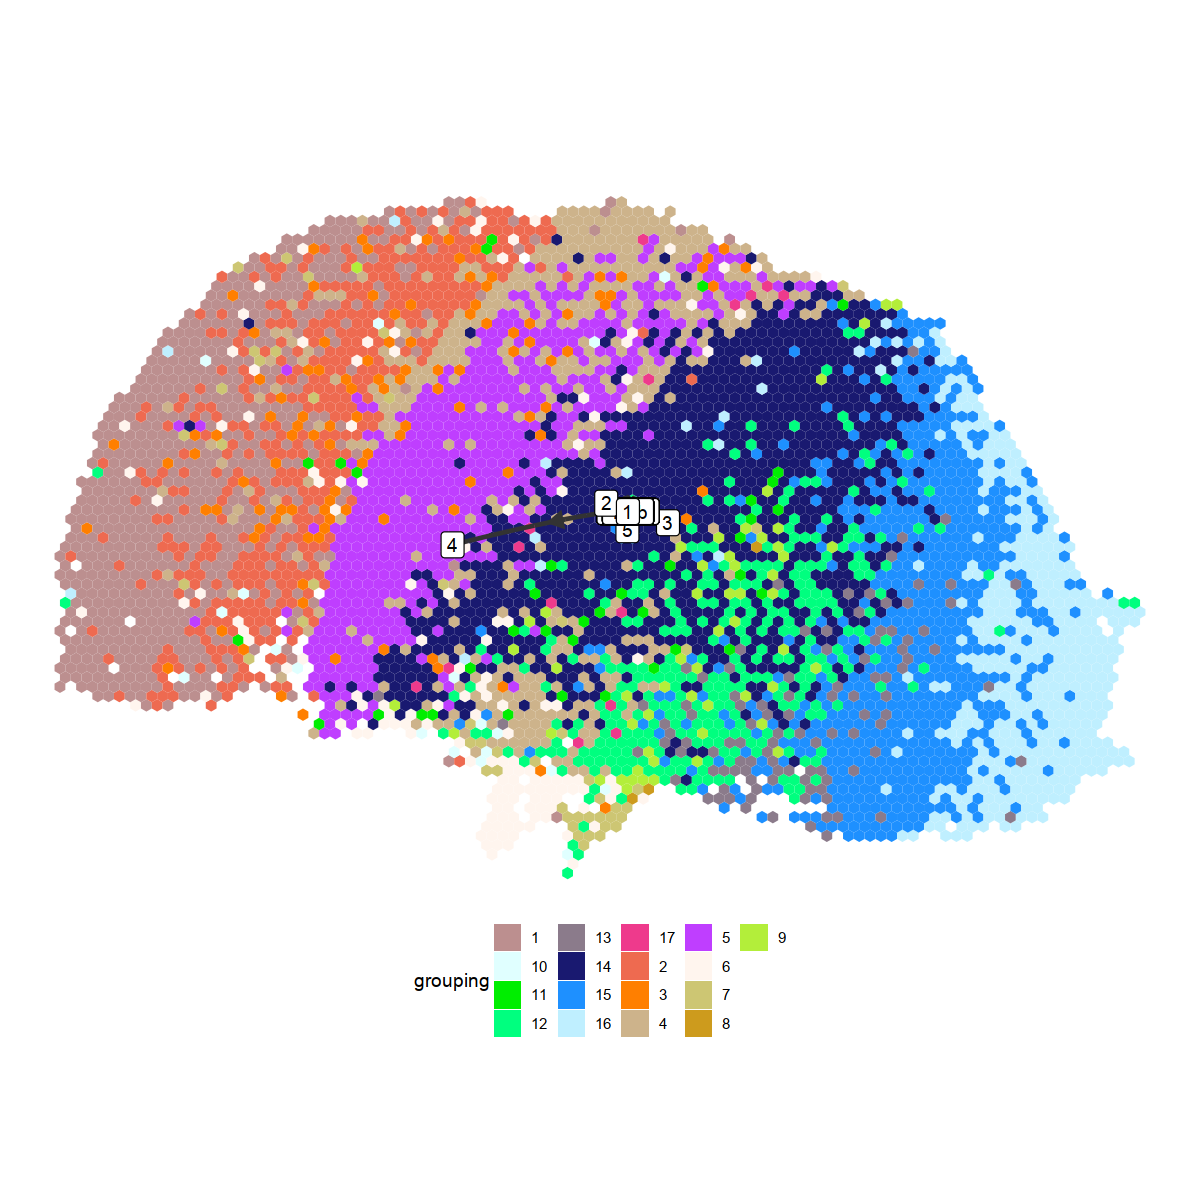

In [11]:
options(repr.plot.width = 10, repr.plot.height = 10)

plot_dimred(model, 
#             dimred = rna@reductions$umap@cell.embeddings,
            size_cells = 0.1,
            grouping = atac.rna.label$atac_new_cluster,
            label_milestones = T)

In [52]:
simplified <- simplify_trajectory(model)
simplified <- simplified %>% add_root(root_milestone_id = "1")

Coloring by grouping



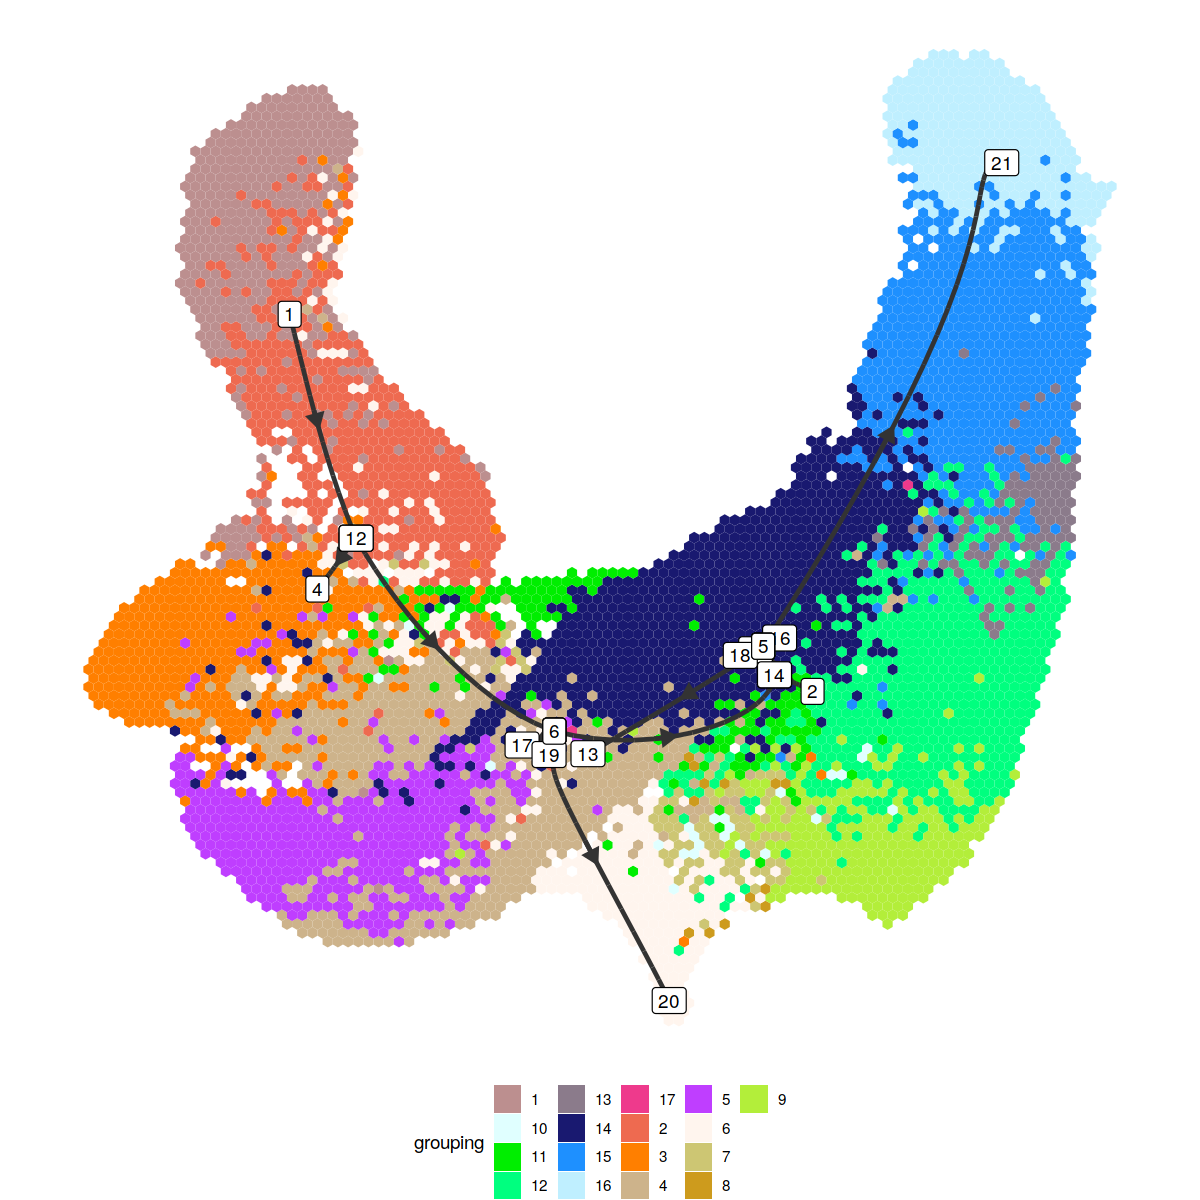

In [54]:
options(repr.plot.width = 10, repr.plot.height = 10)

plot_dimred(simplified, 
            dimred = rna@reductions$umap@cell.embeddings,
            size_cells = 0.1,
            grouping = atac.rna.label$atac_new_cluster,
            label_milestones = T)

Pseudotime not provided, will calculate pseudotime from root milestone



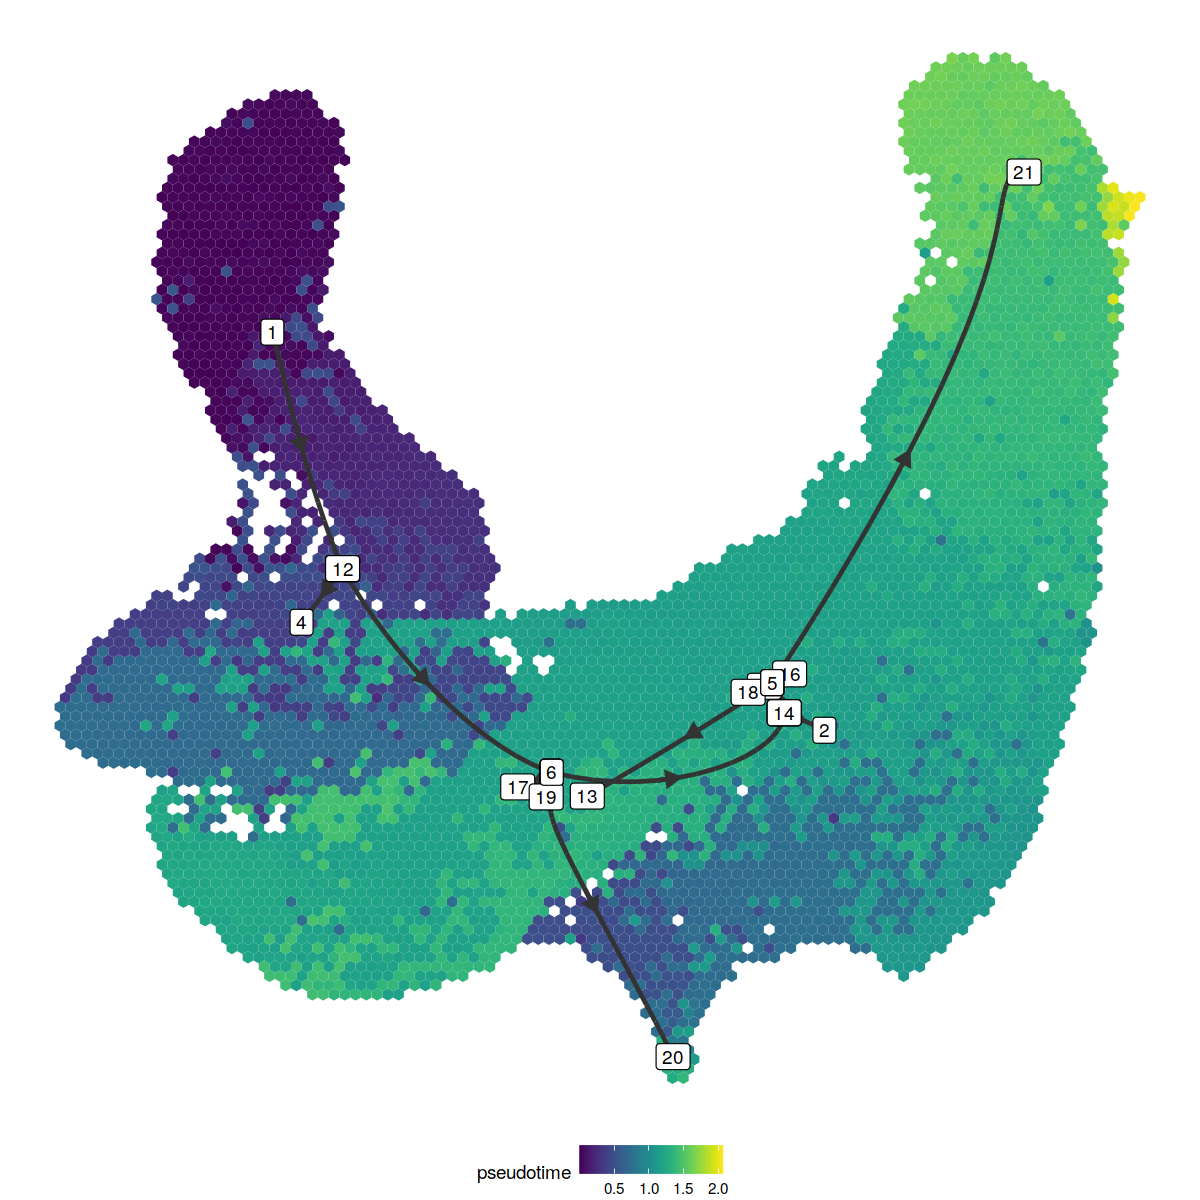

In [53]:
options(repr.plot.width = 10, repr.plot.height = 10)

plot_dimred(simplified, "pseudotime", 
            dimred = rna@reductions$umap@cell.embeddings,
            size_cells = 0.1,
            grouping = atac.rna.label$atac_new_cluster,
            label_milestones = T)